<a href="https://colab.research.google.com/github/yumkim1016/TP1/blob/main/Regression_data_sumup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [회귀모델] 전복나이 구하기

##0. 들어가기에 앞서..  

  나무에 1년에 한 개씩 생기는 '나이테'로 사람들이 나무의 나이를 추정하듯, 전복 또한 껍데기에 1년에 1개씩 아래의 사진처럼 갈색줄이 생기는 데, 이를 'Ring', 즉 고리라고 합니다. 이 고리의 갯수로 전복의 나이를 추정할 수 있는 데, 전복의 크기가 크다고해서 무조건 고리가 많은 것도, 작다고해서 아직 어린 것도 아닐 수 있다고 합니다. 다만, 크기가 커지는 데에 시간이 들 수 밖에 없는 것 처럼, **전복 껍데기의 크기가 클 수록 나이가 많을 확률은 분명하게 올라갑니다.**



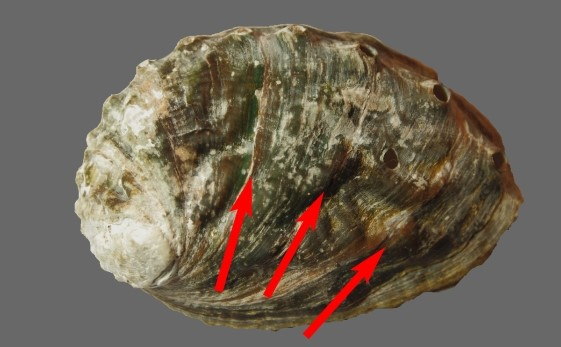

 
  이렇게 크기와 나이가 연관이 있을 수 있는 것 처럼, 전복에는 크기 외에도 나이를 추정할 수 있는 여러가지 특성이 있습니다.      
  우리는 해당 특성들을 가지고 전복의 나이를 추정하는 모델을 개발하였으며, 이번 프로젝트로 기존 모델의 성능을 고도화 시켰습니다.

## 1. 데이터 소개

- 데이터 수: 전처리 전 4,177개, 전처리 후 4,015개     

- 특성(feature): 8개     
  - Sex: 전복의 성별(F, M, I(Infant 유아 = 성별구분이 없음)) / dtype: object
  - Length: 전복 껍데기의 길이 / dtype: float
  - Diameter: 전복 껍데기의 지름 / dtype: float
  - Height: 전복 껍데기의 높이 / dtype: float
  - Whole Weight: 전복 전체 무게 / dtype: float
  - Shucked Weight: 껍데기를 제외한 무게 / dtype: float
  - Viscera Weight: 내장 무게 / dtype: float
  - Shell Weight: 껍데기 무게 / dtype: float

- 타겟(target): 1개
  - Rings: 전복 껍데기에 있는 고리의 갯수(= 전복의 나이) / dtype: int

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Regression_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## 2. 데이터 전처리 및 EDA

### 기본검사

In [4]:
# 결측치 검사
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# 중복데이터 검사
df.duplicated().sum()

0

In [6]:
# 통계치 검사
df.describe()
# Height: min값 0 발견
# Height: 75% 0.165 -> max 1.130 이상치 발견
# 기타 weight특성들에서도 75%와 max값의 갭이 큼, 데이터 확인 필요

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
# 명목형 데이터 오탈자 검사
df.Sex.value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [8]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Encoding: Label Encoding
명목형 데이터의 경우 One-Hot Encoding, Label Encoding 등으로 숫자로의 변환이 필요하다.      
변환하려는 성별 데이터의 경우는 변환되는 숫자의 크기가 성능에 영향이 있지 않으므로, 단순 Label Encoding으로 진행해도 무관하여 간단하게 진행하였다.

In [9]:
encoder = LabelEncoder()
df['Sex_Encoded'] = encoder.fit_transform(df['Sex'])
print(df)

     Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings  Sex_Encoded  
0             0.1010        0.1500     15            2  
1             0.0485        0.0700      7            2  
2           

In [10]:
print('Encoded Values:', df['Sex_Encoded'].unique())
print('Mapping:')
for i, label in enumerate(encoder.classes_):
    print(f'{label} -> {i}')

Encoded Values: [2 0 1]
Mapping:
F -> 0
I -> 1
M -> 2


In [11]:
# column 위치 재정렬(target을 끝 column으로 가져가기 위함)
df = df.reindex(columns=['Sex_Encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'])

### 이상치 체크리스트 
1. Whole weight이 Shucked + Shell 보다 작을 수 없다. 
  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.   
2. Whole weight이 Shucked, Viscera, Shell 무게 셋 중에 하나보다 작을 수 없다.  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  
3. Height가 0일 수 없다.(통계치 검사에서 0 있음 확인) -> Length와 Diameter이 비슷한 수치를 찾아 비슷한 값으로 대체한다.


↓ 1. Whole weight이 Shucked + Shell 보다 작을 수 없다. 
  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  

In [12]:
# 데이터확인
df[df['Whole weight']<df['Shucked weight']+df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
193,1,0.355,0.275,0.085,0.2200,0.0920,0.0600,0.1500,8
236,1,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1
822,1,0.380,0.275,0.095,0.1375,0.0860,0.0585,0.0605,7
1216,1,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5
1219,1,0.325,0.225,0.075,0.1390,0.0565,0.0320,0.0900,6
1264,1,0.455,0.330,0.100,0.3720,0.3580,0.0775,0.1100,8
1302,1,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,8
1430,1,0.230,0.165,0.060,0.0515,0.0190,0.0145,0.0360,4
2127,1,0.400,0.310,0.100,0.1270,0.1060,0.0710,0.0850,7
2627,1,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5


In [13]:
# 데이터 수정 및 재호출하여 변경확인
df.loc[df['Whole weight'] < df['Shucked weight'] + df['Shell weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']
df[df['Whole weight']<df['Shucked weight']+df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


↓ 2. Whole weight이 Shucked, Viscera, Shell 무게 셋 중에 하나보다 작을 수 없다.  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  

In [14]:
# Whole 이 Shucked 보다 작은 데이터 확인
df[df['Whole weight']<df['Shucked weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [15]:
# Whole 이 Viscera 보다 작은 데이터 확인
df[df['Whole weight']<df['Viscera weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [16]:
# Whole 이 Shell 보다 작은 데이터 확인
df[df['Whole weight']<df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [17]:
# 위 해당 row들 Whole weight 고치기
df.loc[df['Whole weight'] < df['Shucked weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']
df.loc[df['Whole weight'] < df['Shell weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']

In [18]:
# 재호출하여 변경확인
df[df['Whole weight']<df['Shucked weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [19]:
# 재호출하여 변경확인
df[df['Whole weight']<df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [20]:
# 데이터 수 확인
df.shape

(4177, 9)

↓ 3. Height가 0일 수 없다.(통계치 검사에서 0 있음 확인) -> Length와 Diameter이 비슷한 수치를 찾아 비슷한 값으로 대체한다.

In [21]:
# Height가 0인 row 확인
df[df['Height']==0]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,1,0.430,0.34,0.0,0.4280,0.2065,0.0860,0.1150,8
3996,1,0.315,0.23,0.0,0.4365,0.0575,0.0285,0.3505,6


In [22]:
# 유사한 Length와 Diameter를 가진 Height로 수정
for index, row in df.iterrows():
    if row['Height'] == 0:
        similar_rows = df[(df['Length'] == row['Length']) & (df['Diameter'] == row['Diameter'])]
        if not similar_rows.empty:
            df.at[index, 'Height'] = similar_rows['Height'].values[0]

In [23]:
# 해당 row 호출하여 변경확인
df.loc[1257:1257]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,1,0.43,0.34,0.12,0.428,0.2065,0.086,0.115,8


In [24]:
df.loc[3996:3996]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3996,1,0.315,0.23,0.09,0.4365,0.0575,0.0285,0.3505,6


In [25]:
# 재호출하여 더블체크
df[df['Height']==0]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [26]:
# 데이터 수 확인
df.shape

(4177, 9)

In [27]:
# 데이터 통계치 재확인
df.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.523992,0.407881,0.139567,0.829424,0.359367,0.180594,0.238831,9.933684
std,0.822240,0.120093,0.099240,0.041724,0.489950,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.010000,0.003000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.442500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Outlier Checking

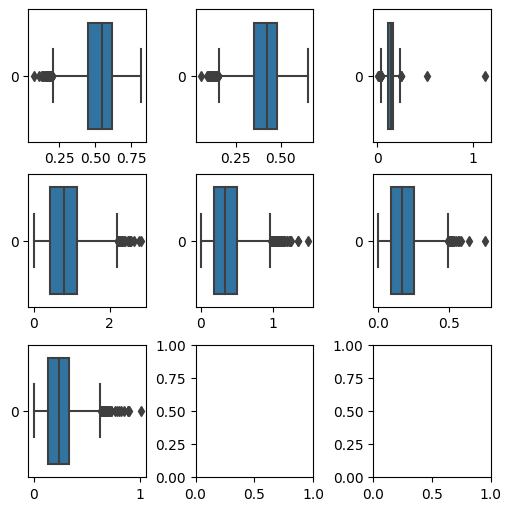

In [28]:
# 각 feature 분포확인

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5,5), constrained_layout=True)

for i, feature in enumerate(df.columns[1:-1]): # 첫번째 특성인 성별은 명목형이고, 끝 특성은 타겟이기때문에 제외
    sns.boxplot(df[feature], ax=ax[int(i/3),int(i%3)], orient='h')
plt.show()

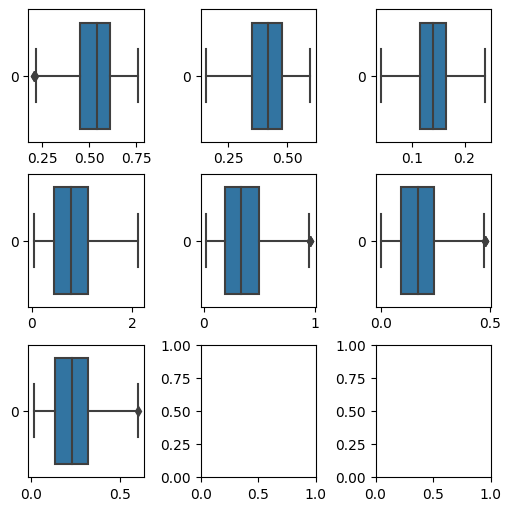

In [29]:
# 아웃라이어 제거 함수 정의
def remove_outliers(data, feature, fence_factor=1.5):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)
  IQR = Q3 - Q1
  lower_fence = Q1 - fence_factor * IQR
  upper_fence = Q3 + fence_factor * IQR
  filtered_data = data[(data[feature] >= lower_fence) & (data[feature] <= upper_fence)]
  return filtered_data

# 아웃라이어 제거 적용 후 분포 
for column in df.columns[1:-1]:
  df = remove_outliers(df, column, fence_factor=1.5)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5,5), constrained_layout=True)
for i, feature in enumerate(df.columns[1:-1]): # 첫번째 특성인 성별은 명목형이고, 끝 특성은 타겟이기때문에 제외
    sns.boxplot(df[feature], ax=ax[int(i/3),int(i%3)], orient='h')
plt.show()

In [30]:
# Outlier 제거 후 shape변화
print(df.shape)

(4015, 9)


### 가설리스트

- 편의상 균일한 타원형 반구라는 가정 및 
- 빈 속이 전체의 50%라고 임의로 가정한다.

전복 껍데기가 성장하는데에는 시간이 걸리기 때문에,  

- `가설 1` 전복 껍데기의 부피가 타겟과 관련이 있을 것이다.     
  - 부피: (4/3) * π * a * b * c * 1/2(반구) * 50%(빈 속 제외)
- `가설 2` 전복 껍데기의 밀도가 타겟과 관련이 있을 것이다.
  - 밀도: 무게(Shell weight) / 부피

해당 가설들을 기반으로 'Volume', 'Density' feature들을 추가해본다.

In [31]:
# features 추가 및 reindex(target을 끝 column으로 가져가기 위함)
df['Volume'] = 4/3 * math.pi * df['Length'] * df['Diameter'] * df['Height'] * 1/2 * 1/2
df['Density'] = df['Shell weight'] / df['Volume']
df = df.reindex(columns=['Sex_Encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Volume', 'Density', 'Rings'])

In [32]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,7


In [33]:
# 데이터 저장 reg_df
reg_df = df
reg_df.to_csv('reg_df.csv', index=False)

### Log Transformation(Target)
회귀 모델링의 결과는 타겟의 분포가 정규분포 형태를 띄어야 성능이 높은 것으로 통계적으로 알려져있으며,       
따라서 Log 변형은 feature 보다 target에 씌우는 것이 더 효과적이다.

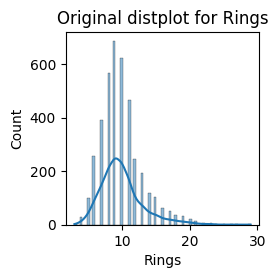

In [34]:
# Transformation 전 Target 분포확인
plt.figure(figsize=(2.5, 2.5))
plt.title('Original distplot for Rings')
sns.histplot(df['Rings'], kde=True)
plt.show()

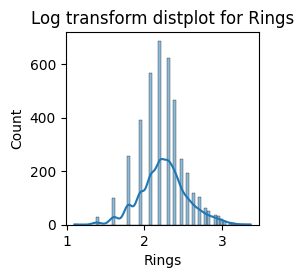

In [35]:
# Log Transformation 적용
reg_df['Rings'] = np.log(df['Rings'])

# Transformation 후 Target 분포확인
plt.figure(figsize=(2.5, 2.5))
plt.title('Log transform distplot for Rings')
sns.histplot(reg_df['Rings'], kde=True)
plt.show()

### Scaling: StandardScaler 사용
StandardScalar은 Outlier에 민감하며, 정규분포형태가 아닌경우 적용하면 좋다. 단, Scaling은 반드시 TRAIN SET에만 진행한다.

In [36]:
# train/val/test set split
features = reg_df.drop('Rings', axis=1)
target = reg_df['Rings']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

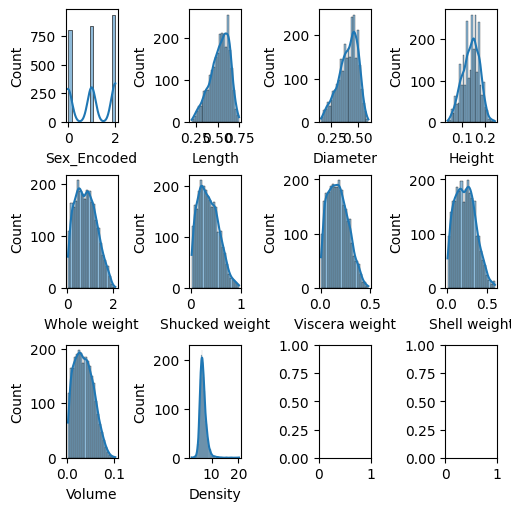

In [37]:
# 스케일링 전 각 feature 분포확인
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(5,5), constrained_layout=True)

for i, feature in enumerate(X_train.columns):
    sns.histplot(X_train[feature], ax=ax[int(i//4),int(i%4)], kde=True)
plt.show()

In [38]:
# StandardScaler
features_to_scale = list(X_train.columns[1:]) #Sex_Encoded는 Scaling되면 안됨!
scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
X_train.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density
count,2569.000000,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03,2.569000e+03
mean,1.052939,2.572226e-16,2.765834e-17,3.014759e-16,8.297502e-18,-8.574085e-17,1.410575e-16,4.701918e-17,1.631842e-16,-5.531668e-18
std,0.819068,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00
min,0.000000,-2.913253e+00,-2.780821e+00,-2.813477e+00,-1.735669e+00,-1.665439e+00,-1.708827e+00,-1.761582e+00,-1.698485e+00,-3.483347e+00
25%,0.000000,-6.359444e-01,-6.388451e-01,-6.823819e-01,-8.139667e-01,-7.989210e-01,-8.152161e-01,-8.100300e-01,-8.128377e-01,-6.450545e-01
50%,1.000000,1.383405e-01,1.300694e-01,2.798324e-02,-3.815378e-02,-9.222223e-02,-7.137214e-02,-3.039751e-02,-7.308198e-02,-1.420755e-01
75%,2.000000,7.759869e-01,7.342165e-01,7.383484e-01,7.308736e-01,7.043746e-01,6.974330e-01,6.932614e-01,7.232491e-01,4.627711e-01
max,2.000000,2.005733e+00,2.107278e+00,2.869444e+00,2.873972e+00,3.044222e+00,3.033802e+00,2.940202e+00,3.330854e+00,1.104173e+01


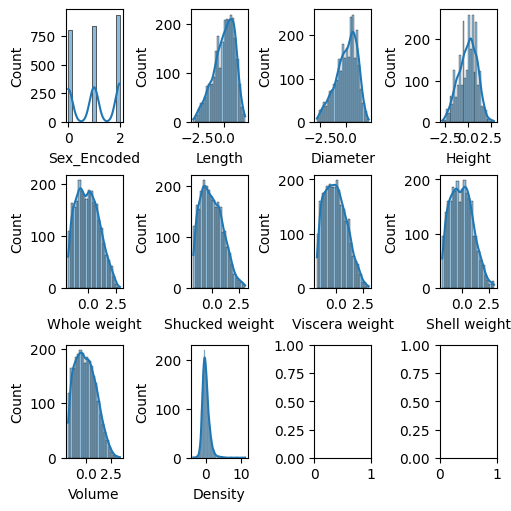

In [39]:
# 스케일링 후 각 feature 분포확인
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(5,5), constrained_layout=True)

for i, feature in enumerate(X_train.columns):
    sns.histplot(X_train[feature], ax=ax[int(i//4),int(i%4)], kde=True)
plt.show() # 분포도는 변하지않고 데이터값은 변화하였다(스케일러 적용됨 확인)

In [40]:
# DF 변환 및 데이터 저장

X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [41]:
y_train.head()

3547    2.197225
3857    2.772589
3110    2.079442
3690    2.564949
2786    2.302585
Name: Rings, dtype: float64

### Feature importance 분석




In [42]:
# Feature Importance
features = X_train
target = y_train

# Target Continuous로 변형
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# 랜덤 포레스트 분류기 모델 생성
rf = RandomForestClassifier(random_state=42)
rf.fit(features, target)

# Feature importance 계산
importances = rf.feature_importances_

# 결과 출력
for feature, importance in zip(features.columns, importances):
    print(f'{feature}: {importance}')

Sex_Encoded: 0.0341588488213033
Length: 0.08998362615149258
Diameter: 0.08781489357365266
Height: 0.07410408922959184
Whole weight: 0.11194987664465483
Shucked weight: 0.12474144499314778
Viscera weight: 0.12044379714780225
Shell weight: 0.125457171872467
Volume: 0.11575497232596972
Density: 0.11559127923991816


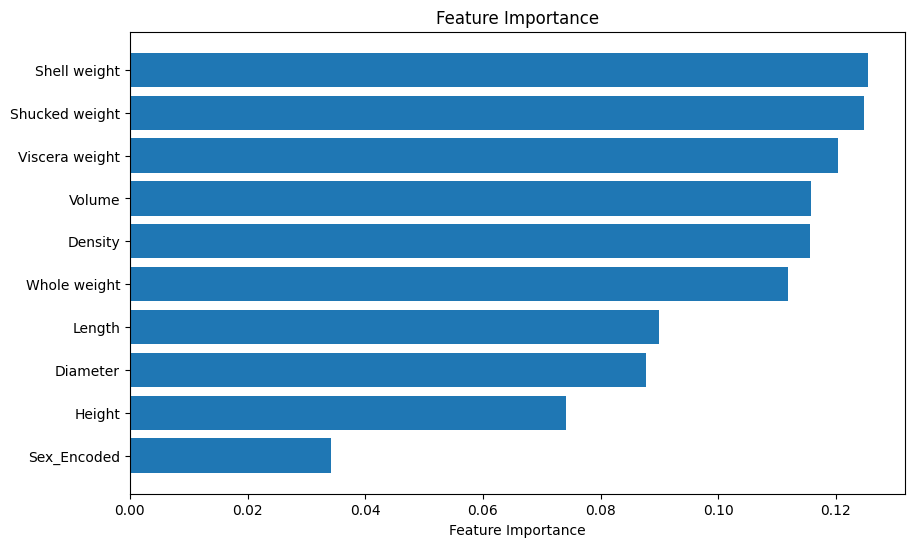

In [43]:
# bar plot으로 결과 시각화, 높은순서대로 표시

feature_names = features.columns
sorted_indices = np.argsort(importances)
pos = np.arange(sorted_indices.shape[0]) + 0.5

plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_indices], align='center')
plt.yticks(pos, feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

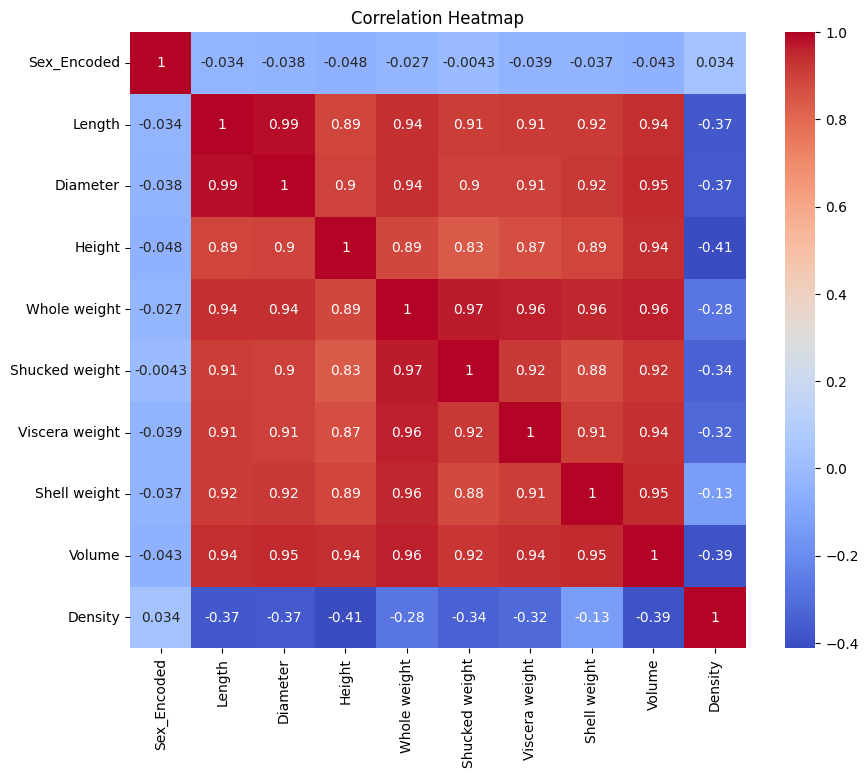

In [44]:
# Heatmap

# 상관관계 계산
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [45]:
# 가장 연관성 없어보이는 Sex_Encoded, Density features drop
reg_fi = df.drop('Density', axis=1)
reg_fi = df.drop('Sex_Encoded', axis=1)

# 데이터 저장 reg_fi
reg_fi.to_csv('reg_fi.csv', index=False) # 테스트 해보았으나 유의미한 성능변화가 일어나지않아 사용x

### PCA

In [46]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,2.708050
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,1.945910
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,2.197225
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,2.302585
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,1.945910


In [47]:
# PCA는 독립변수만을 위한 작업이니, target 삭제
df_pca = df.drop('Rings', axis=1)

# 모든 독립변수 개수(10개) 만큼 주성분 개수 설정해서 분석하기
pca = PCA(n_components=10)
pca_array = pca.fit_transform(df_pca)
pca_df = pd.DataFrame(pca_array, index=df_pca.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10
0,2.294618,-0.886560,-0.064304,0.013484,0.039041,0.015054,0.017046,-0.003960,-0.015049,0.000366
1,1.274039,-0.926855,-0.541770,0.031488,-0.024660,-0.001318,-0.003316,0.000300,-0.001133,0.001467
2,-0.173479,1.041250,-0.197966,-0.054519,0.022643,0.001308,0.015385,0.000554,-0.005124,-0.000166
3,0.601764,-0.939595,-0.264024,-0.007645,-0.003019,0.002039,-0.001460,0.011149,-0.019192,-0.002340
4,1.044736,0.065363,-0.620966,0.047917,-0.036749,-0.005772,0.003946,-0.004936,-0.006926,0.001867


In [48]:
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산비율(고윳값)':pca.explained_variance_, 
                       '기여율': pca.explained_variance_ratio_}, index = np.array([f"pca{num+1}" for num in range(pca.n_components)]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산비율(고윳값),기여율,누적기여율
pca1,1.913825,0.671058,0.671058
pca2,0.675863,0.236983,0.908040
pca3,0.256217,0.089839,0.997879
pca4,0.002978,0.001044,0.998924
pca5,0.001654,0.000580,0.999504
pca6,0.000773,0.000271,0.999774
pca7,0.000353,0.000124,0.999898
pca8,0.000144,0.000051,0.999949
pca9,0.000136,0.000048,0.999997
pca10,0.000010,0.000003,1.000000


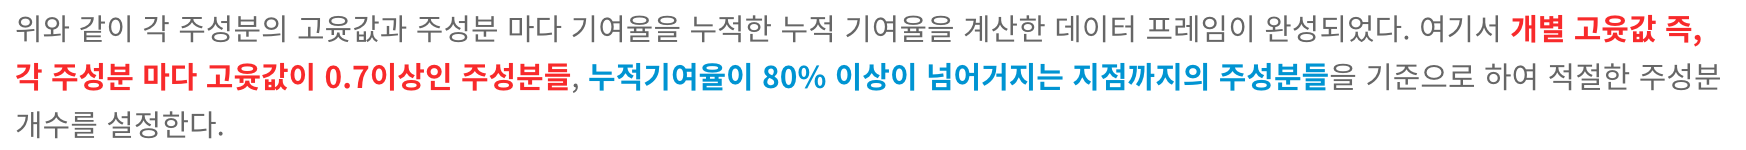

누적 기여율이 평탄해지는 pca3, 주성분 3개로 진행해본다.

In [49]:
df.shape

(4015, 11)

In [50]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,2.708050
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,1.945910
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,2.197225
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,2.302585
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,1.945910


In [51]:
pca = PCA(n_components=3)
pca_array = pca.fit_transform(df_pca)
pca_df = pd.DataFrame(pca_array, index=df_pca.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2,pca3
0,2.294618,-0.886560,-0.064304
1,1.274039,-0.926855,-0.541770
2,-0.173479,1.041250,-0.197966
3,0.601764,-0.939595,-0.264024
4,1.044736,0.065363,-0.620966


In [52]:
pca_df['Rings'] = df['Rings']

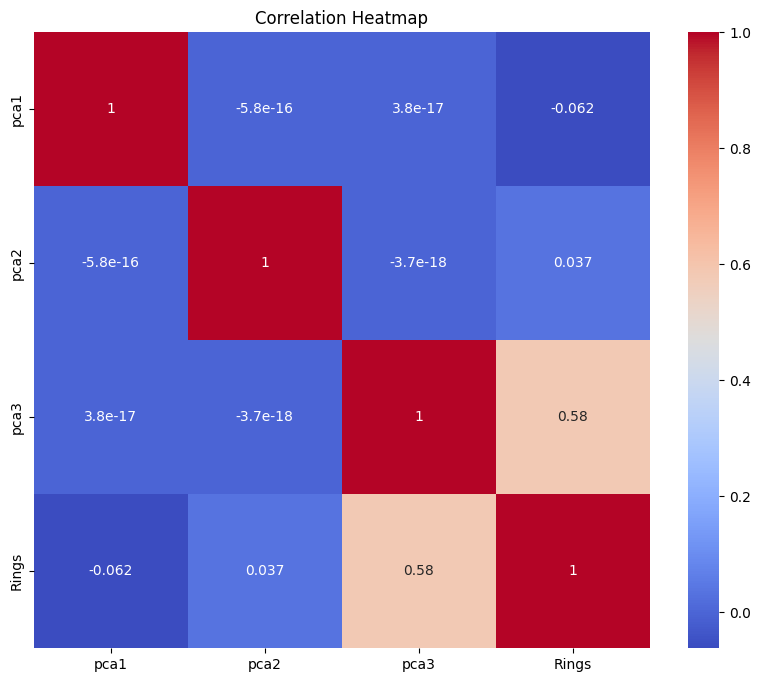

In [53]:
# Heatmap

# 상관관계 계산
features = pca_df
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

## 2. 모델링

In [54]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time

### BEST ML(LGBM Regressor + GridSearchCV)

In [55]:
# loss
def mse_log(y_true, y_pred):
  y_true = np.exp(y_true)
  y_pred = np.exp(y_pred)
  return mean_squared_error(y_true, y_pred)

# 정확도 계산
def eval_accuracy_log(y_true, y_pred):
	# 오차율 구하는 과정    
	# np.mean() 메서드의 이유는 미니배치 처리를 고려하여 하나의 지표로 묶어주기 위함 입니다. 
  y_true = np.exp(y_true)
  y_pred = np.exp(y_pred)
  mdiff = np.mean(np.abs((y_pred - y_true) / y_true))
  
  # 1 에서 오차율을 빼 정확도를 구합니다. 
  return 1 - mdiff

In [56]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('regression', LGBMRegressor())])

param_grid = {'regression__max_depth': [-1, 3, 6, 9],
              'regression__n_estimators': [100, 150, 200]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(mse_log))

In [57]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"LGBM 모델 학습 시간: {end-start}")
print(f'최적 하이퍼파라미터 : {grid.best_params_}')

LGBM 모델 학습 시간: 8.145302295684814
최적 하이퍼파라미터 : {'regression__max_depth': -1, 'regression__n_estimators': 200}


In [58]:
# 예측
y_test_pred = grid.best_estimator_.predict(X_test)

In [59]:
print("Train: ", grid.best_score_)
print(f"Test: Loss = {mse_log(y_test, y_test_pred):.3f}, Accuracy = {eval_accuracy_log(y_test, y_test_pred):.3f}")

Train:  4.786163972494828
Test: Loss = 5.221, Accuracy = 0.844


### BEST DL
- 모델 구성:
  - 은닉층 6개 + 출력층 1개 + 입력층 1개 = 8개
  - 활성화 함수 elu
  - Batch Normalization, Drop out: 성능/속도 상승 및 과적합 방지용
  - Early Stopping: val_acc 기준으로 적용(setting epoch 1,000)

In [60]:
# 딥러닝의 회귀모델구현의 경우, 데이터에 별도로 EDA를 진행
# EDA: https://github.com/Thingjae9/team_project/blob/main/model1_DL/final/new_eda.ipynb
# ㄴcsv: https://github.com/Thingjae9/team_project/blob/main/model1_DL/final/final_model1.csv
# ㄴmodel: https://github.com/Thingjae9/team_project/blob/main/model1_DL/final/real_final_model.ipynb

In [61]:
from sklearn.metrics import mean_absolute_error
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler,StandardScaler
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import tensorflow
from keras import backend as K
from sklearn.model_selection import train_test_split
import os
import time

In [62]:
df = pd.read_csv('final_model1.csv')

df.drop(['Unnamed: 0'], axis = 1, inplace = True)

feature_cols = df.columns.tolist()
feature_cols.remove('Target')
target_cols = ['Target']
remove_list = ['Sex_I','Sex_F','Sex_M']
for col in remove_list:
    feature_cols.remove(col)
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', StandardScaler())])
X = df.drop(['Target'], axis = 1)
y = df['Target']

# target 칼럼 log scale 적용
y = np.log(y)

# train test split
X_train, X_test = train_test_split(X, test_size= 0.2, random_state = 42)
y_train, y_test = train_test_split(y, test_size= 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val = train_test_split(y_train, test_size = 0.2, random_state = 42)

# pipeline을 통해 normalize와 standard scaler 적용
X_train[feature_cols] = pipeline.fit_transform(X_train[feature_cols])
X_test[feature_cols] = pipeline.transform(X_test[feature_cols])
X_val[feature_cols] = pipeline.transform(X_val[feature_cols])

In [63]:
def custom_opt2(n):
    opt = tf.keras.optimizers.Adam(learning_rate=n)
    return opt

In [64]:
def accuracy(y_true, y_pred):
    y_true = tf.math.exp(y_true)
    y_pred = tf.math.exp(y_pred)
    return 1 - tf.abs((y_true - y_pred) / y_true)

In [65]:
# Best hyperparameters: {'activation': 'elu', 'batch_size': 128, 'learning_rate': 0.006}

model = Sequential()
model.add(Dense(256, activation='elu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())  # BatchNormalization 추가
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())  # BatchNormalization 추가
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())  # BatchNormalization 추가
model.add(Dropout(0.2))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(8, activation='elu'))
model.add(Dense(8, activation='elu'))
model.add(Dense(1, activation='elu'))

# 모델 컴파일
model.compile(loss='mse', optimizer=custom_opt2(0.006), metrics=[accuracy])

# early stopping 구현 - 커스텀 정확도 기준
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
start_time = time.time()
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose = 0)
end_time = time.time()

print("==== Final Model ====")
print("걸린시간 :",end_time-start_time)
print("==== train los acc ====")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 2)
print("==== val los acc ====")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)

==== Final Model ====
걸린시간 : 14.239182710647583
==== train los acc ====
84/84 - 0s - loss: 0.0345 - accuracy: 0.8604 - 203ms/epoch - 2ms/step
==== val los acc ====
21/21 - 0s - loss: 0.0375 - accuracy: 0.8517 - 65ms/epoch - 3ms/step
